# RNA-seq Differential Expression Analysis (Without small RNA analysis)
## Centriolar mRNA Localization Project

**Experimental Design:**
- 3 cell lines: HeLa, RPE-p53KO, KE37-WT (2 replicates each)
- 1 control: RPE-SAS6KO (no centrioles)
- Goal: Identify mRNAs enriched at isolated centrioles

- Assumption
in SAS6KO, the RNA are mainly from cytoplasm and other organelles
In the 6 other groups, RNAs are mainly from centrioles, cytoplasm, other organelles and some maybe cell line specific genes's expression


    Centriole_RNA = intersection( RPEp53_RNA.Average - RPESAS6_RNA, HeLa_RNA.Average - RPESAS6_RNA,
                                 KE37_RNA.Average - KE37SAS6_RNA)
                  = union( RPEp53_RNA.Average - RPESAS6_RNA, HeLa_RNA.Average - RPESAS6_RNA,
                                 KE37_RNA.Average - KE37SAS6_RNA) - cellline_specific_genes_RNA

    cellline_specific_genes = union( HeLa_RNA.Average, KE37_RNA.Average)

## 1. Load Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
counts_df = pd.read_csv('/home/jiguo/data/data/reverse_stranded/counts/counts.txt', 
                        sep='\t', comment='#')
counts_df

,Geneid,Chr,Start,End,Strand,Length,rep1_0.Aligned.sortedByCoord.out.bam,rep1_1.Aligned.sortedByCoord.out.bam,rep3_1.Aligned.sortedByCoord.out.bam,control.Aligned.sortedByCoord.out.bam,rep2_1.Aligned.sortedByCoord.out.bam,rep2_0.Aligned.sortedByCoord.out.bam,rep3_0.Aligned.sortedByCoord.out.bam
0,ENSG00000290825.2,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;c...,11121;11125;11410;11411;11426;11770;11819;1182...,11211;11211;11671;11671;11671;11844;11844;1184...,+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;...,2898,0,0,0,0,0,0,1
1,ENSG00000223972.6,chr1;chr1;chr1;chr1;chr1;chr1,12010;12179;12613;12975;13221;13453,12057;12227;12697;13052;13374;13670,+;+;+;+;+;+,632,0,0,0,0,0,0,0
2,ENSG00000310526.1,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;c...,14356;14356;14356;14356;14356;14356;14356;1436...,14829;14829;14829;14829;14829;14829;14829;1482...,-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;...,6775,95,91,321,45,28,36,991
3,ENSG00000227232.6,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1,14696;14970;15796;16607;16858;17233;17606;1791...,14829;15038;15947;16765;17055;17368;17742;1806...,-;-;-;-;-;-;-;-;-;-,1380,0,0,0,0,0,0,0
4,ENSG00000278267.1,chr1,17369,17436,-,68,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
78927,ENSG00000303867.1,KI270751.1;KI270751.1;KI270751.1;KI270751.1;KI...,2579;3475;3479;3479;3482;4368;4368;4368;4368;7...,3883;3883;3883;4490;3883;4490;4490;4490;4490;7...,-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;...,10647,0,0,0,0,0,0,0
78928,ENSG00000303902.1,KI270751.1;KI270751.1;KI270751.1;KI270751.1;KI...,34096;34251;42980;44851;44857;44879;44899;4491...,34151;34326;43109;45034;45034;45034;45034;4503...,+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;...,3770,0,0,0,0,0,0,0
78929,ENSG00000306528.1,KI270751.1;KI270751.1;KI270751.1;KI270751.1;KI...,133801;133807;135162;135199;139047,134122;134122;135236;135236;139253,-;-;-;-;-,604,22,14,1,0,0,0,0
78930,ENSG00000297844.1,KI270753.1;KI270753.1,43135;44107,43518;44491,+;+,769,0,0,1,0,0,0,0


## 2. Create Sample Metadata

In [3]:
# set gene_id as index
counts_df = counts_df.set_index('Geneid')


In [4]:
# add Genesymbol column
import mygene
mg = mygene.MyGeneInfo()
gene_ids = counts_df.index.str.split(".").str[0]
gene_info = mg.querymany(
    gene_ids,
    scopes="ensembl.gene",
    fields="symbol",
    species="human",
    as_dataframe=True
)

# remove duplicated indices
gene_info = gene_info[~gene_info.index.duplicated(keep="first")]

counts_df["Genesymbol"] = gene_info["symbol"].reindex(gene_ids).values


Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
48 input query terms found dup hits:	[('ENSG00000291072', 2), ('ENSG00000228044', 2), ('ENSG00000226506', 2), ('ENSG00000261600', 2), ('E
60 input query terms found no hit:	['ENSG00000304412', 'ENSG00000309633', 'ENSG00000288982', 'ENSG00000300721', 'ENSG00000300484', 'ENS


In [5]:
# fill NaN values in Genesymbol with the original Geneid
counts_df["Genesymbol"] = counts_df["Genesymbol"].fillna(
    pd.Series(gene_ids, index=counts_df.index)
)


In [6]:
# remove annotation columns 
counts_cols = [col for col in counts_df.columns if 'Aligned' in col]
counts = counts_df[counts_cols]
counts

,rep1_0.Aligned.sortedByCoord.out.bam,rep1_1.Aligned.sortedByCoord.out.bam,rep3_1.Aligned.sortedByCoord.out.bam,control.Aligned.sortedByCoord.out.bam,rep2_1.Aligned.sortedByCoord.out.bam,rep2_0.Aligned.sortedByCoord.out.bam,rep3_0.Aligned.sortedByCoord.out.bam
Geneid,,,,,,,
ENSG00000290825.2,0,0,0,0,0,0,1
ENSG00000223972.6,0,0,0,0,0,0,0
ENSG00000310526.1,95,91,321,45,28,36,991
ENSG00000227232.6,0,0,0,0,0,0,0
ENSG00000278267.1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...
ENSG00000303867.1,0,0,0,0,0,0,0
ENSG00000303902.1,0,0,0,0,0,0,0
ENSG00000306528.1,22,14,1,0,0,0,0


In [7]:
counts.columns = counts.columns.str.replace('.Aligned.sortedByCoord.out.bam', '')
sample_info = pd.DataFrame({
    'sample_id' : ['rep1_0', 'rep1_1', 'rep2_0', 'rep2_1', 'rep3_0', 'rep3_1','control'],
    'cell_line' : ['HeLa', 'HeLa', 'RPE-p53KO', 'RPE-p53KO', 'KE37-WT', 'KE37-WT','RPE-SAS6KO'],
    'condition' : ['with_centrioles'] * 6 + ['without_centrioles'],
    'replicate' : [1, 2] * 3 + [1]
}).set_index('sample_id')

In [8]:
counts.columns = counts.columns.str.replace('.Aligned.sortedByCoord.out.bam', '')

In [9]:
# save the metadata
sample_info.to_csv('/home/jiguo/data/data/reverse_stranded/counts/sample_metadata.csv')

In [10]:
counts.to_csv('/home/jiguo/data/data/reverse_stranded/counts/annotated_counts.txt', sep='\t')

In [10]:
sample_info

,cell_line,condition,replicate
sample_id,,,
rep1_0,HeLa,with_centrioles,1
rep1_1,HeLa,with_centrioles,2
rep2_0,RPE-p53KO,with_centrioles,1
rep2_1,RPE-p53KO,with_centrioles,2
rep3_0,KE37-WT,with_centrioles,1
rep3_1,KE37-WT,with_centrioles,2
control,RPE-SAS6KO,without_centrioles,1


## 3. Filter Low-Count Genes

In [11]:
# keep genes with at least 1 counts in at least 1 samples
keep = (counts>=1).sum(axis=1) >= 1
counts_filtered = counts[keep]
print(f'filtered from {counts.shape[0]} to {counts_filtered.shape[0]} genes')

filtered from 78932 to 67176 genes


In [13]:
counts_filtered.to_csv('/home/jiguo/data/data/reverse_stranded/counts/filtered_annotated_counts.txt', sep='\t')

In [13]:
library_sizes = counts_filtered.sum(axis=0)
cpm = counts_filtered.div(library_sizes, axis=1) * 1e6 # axis =1 for meaning column-wise division
log_cpm=np.log2(cpm + 1)  # log2 transform with pseudocount of 1
print("library sizes:\n", library_sizes)

library sizes:
 control    141404928
rep3_1     117089491
rep2_1     139336470
rep1_1     163383482
rep1_0     117562320
rep3_0      68407431
rep2_0     157378275
dtype: int64


## 4. PCA analysis

In [29]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(log_cpm.T)  # transpose to have samples as rows

In [30]:
# Create PCA fataframe
pca_df = pd.DataFrame(
    data=pca_result, 
    columns=['PC1', 'PC2'], 
    index=counts_filtered.columns)


In [31]:
pca_df = pca_df.join(sample_info)

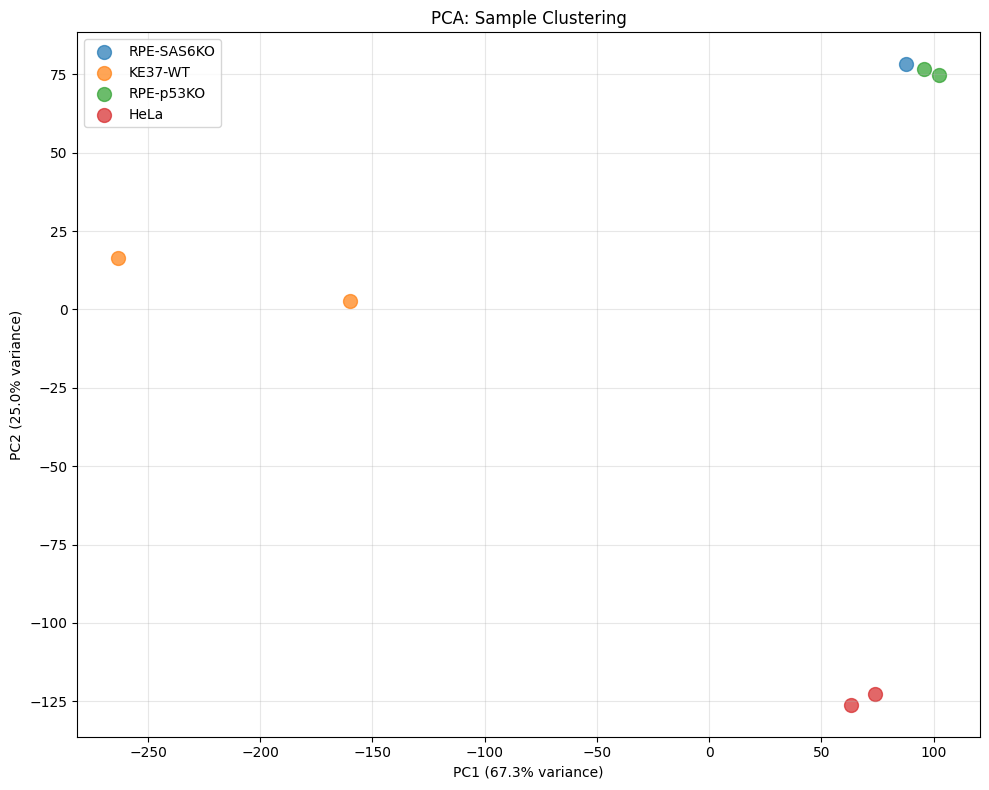

In [32]:
# Plot PCA
plt.figure(figsize=(10, 8))
for cellline in pca_df['cell_line'].unique():
    mask = pca_df['cell_line'] == cellline
    plt.scatter(pca_df.loc[mask, 'PC1'], 
                pca_df.loc[mask, 'PC2'],
                label=cellline, s=100, alpha=0.7)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title('PCA: Sample Clustering')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. other analysis

#### - The difference between RPE-p53(-) and RPE-SAS6(-)

In [33]:
centriole_samples = sample_info[(sample_info['condition']=='with_centrioles') & (sample_info['cell_line']=='RPE-p53KO')].index
control_samples = sample_info[sample_info['condition']=='without_centrioles'].index
# use CPM values
centriole_counts = log_cpm[centriole_samples]
control_counts = log_cpm[control_samples]

# calculate mean expression and fold change
mean_centrioles = centriole_counts.mean(axis=1)
control_expr = control_counts.mean(axis=1)
fold_change = mean_centrioles - control_expr
mean_expr = (mean_centrioles + control_expr) / 2

In [34]:
from scipy.stats import gaussian_kde
# calculate the point density
xy = np.vstack([mean_expr, fold_change])
z = gaussian_kde(xy)(xy)

In [ ]:
# save the list of significant genes
significant_genes = fold_change[(fold_change >= 1) & (mean_expr >= 5)]
significant_genes.to_csv('/home/jiguo/SeqAna_Pipe/significant_genes_RPE-p53KO_vs_Control.txt', sep='\t', header=['Log2_Fold_Change'])

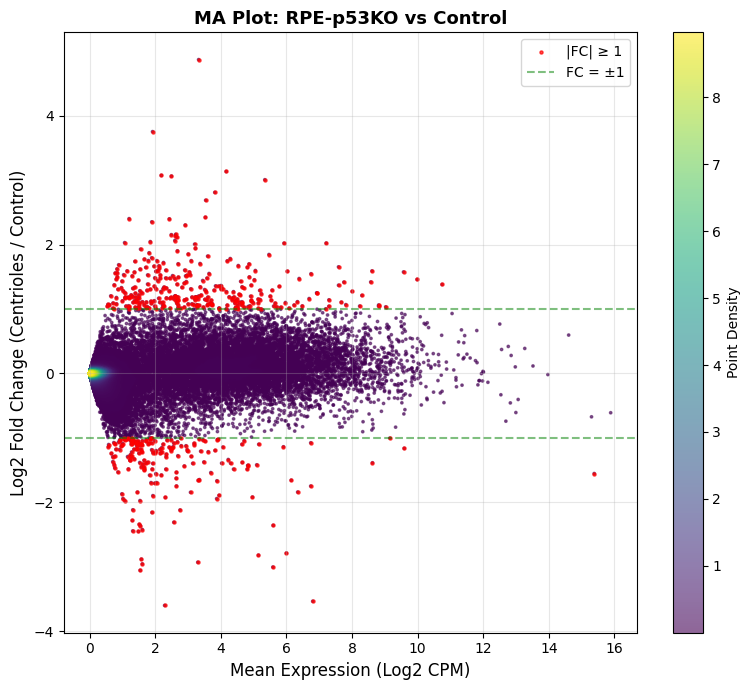

In [36]:

fig, ax1 = plt.subplots(1, 1, figsize=(8, 7))

# === MA Plot with Density ===
idx = z.argsort()
x, y, z_sorted = mean_expr.iloc[idx], fold_change.iloc[idx], z[idx]

scatter = ax1.scatter(x, y, c=z_sorted, s=3, cmap='viridis', alpha=0.6)
# highlight the significant points
significant = fold_change.abs() >= 1
ax1.scatter(mean_expr[significant], fold_change[significant], 
            color='red', s=5, alpha=0.7, label='|FC| ≥ 1')
plt.colorbar(scatter, ax=ax1, label='Point Density')

ax1.axhline(1, color='green', linestyle='--', linewidth=1.5, alpha=0.5, label='FC = ±1')
ax1.axhline(-1, color='green', linestyle='--', linewidth=1.5, alpha=0.5)

ax1.set_xlabel('Mean Expression (Log2 CPM)', fontsize=12)
ax1.set_ylabel('Log2 Fold Change (Centrioles / Control)', fontsize=12)
ax1.set_title('MA Plot: RPE-p53KO vs Control', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Filter the cell line specific genes

- minimize the distance between KE37 and HeLa, and RPE p53(-)
- remove the specifically enriched genes in KE37 and HeLa

In [12]:
# For the three cell lines, identify cellline-specific genes
RPE_samples = sample_info[sample_info['cell_line']=='RPE-p53KO'].index
HeLa_samples = sample_info[sample_info['cell_line']=='HeLa'].index
# use original values instead of CPM
RPE_counts = counts_filtered[RPE_samples]
HeLa_counts = counts_filtered[HeLa_samples]

# calculate mean expression and fold change
mean_RPE = RPE_counts.mean(axis=1)
mean_HeLa = HeLa_counts.mean(axis=1)
fold_change = mean_RPE - mean_HeLa

#### Removed the all genes only expressed in KE37 and HeLa but not in RPE1, 26878 in total
- Here we only use KE37 and HeLa to amplify the 

In [13]:
# Select centriole-specific genes, use fold change to filter instead of mean expression
threshold = 0
HeLa_specific = (mean_RPE <= threshold) & (mean_HeLa > 0)  # output the genes only exxpressed in HeLa
HeLa_genes = HeLa_specific[HeLa_specific].index
print(f'Number of HeLa-specific genes: {len(HeLa_genes)}')

Number of HeLa-specific genes: 23854


In [14]:
sample_info

,cell_line,condition,replicate
sample_id,,,
rep1_0,HeLa,with_centrioles,1
rep1_1,HeLa,with_centrioles,2
rep2_0,RPE-p53KO,with_centrioles,1
rep2_1,RPE-p53KO,with_centrioles,2
rep3_0,KE37-WT,with_centrioles,1
rep3_1,KE37-WT,with_centrioles,2
control,RPE-SAS6KO,without_centrioles,1


In [ ]:
# For the three cell lines, identify cellline-specific genes
# RPE_samples = sample_info[sample_info['cell_line']=='RPE-p53KO'].index
ke37_samples = sample_info[sample_info['cell_line']=='KE37-WT'].index
# use original values instead of CPM
RPE_counts = counts_filtered[RPE_samples]
ke37_counts = counts_filtered[ke37_samples]

# calculate mean expression and fold change
mean_RPE = RPE_counts.mean(axis=1)
mean_ke37 = ke37_counts.mean(axis=1)
fold_change = mean_RPE - mean_ke37
# Select centriole-specific genes
threshold = 0
ke37_specific = (mean_RPE <= threshold) & (mean_ke37 > 0)  # output the genes only exxpressed in HeLa
ke37_genes = ke37_specific[ke37_specific].index
print(f'Number of KE37-specific genes: {len(ke37_genes)}')

Number of KE37-specific genes: 17258


In [17]:
# combine KE37 specific genes and HeLa specific genes into a single list
cellline_specific_genes = pd.Index.union(HeLa_genes, ke37_genes)
print(f'Total number of cellline-specific genes: {len(cellline_specific_genes)}')

Total number of cellline-specific genes: 26747


## Extract centriole-specific genes + Visualization/

In [18]:

centriole_samples = sample_info[sample_info['condition']=='with_centrioles'].index
control_samples = sample_info[sample_info['condition']=='without_centrioles'].index
# use original values instead of CPM
centriole_counts = counts_filtered[centriole_samples]
control_counts = counts_filtered[control_samples]
# calculate mean expression and fold change
mean_centrioles = centriole_counts.mean(axis=1)
control_expr = control_counts.mean(axis=1)
fold_change = mean_centrioles - control_expr

In [19]:
# Select centriole-specific genes
threshold = 0
centriole_specific = (control_expr <= threshold) & (mean_centrioles > 0)  # Must be expressed in centrioles
centriole_genes = centriole_specific[centriole_specific].index
print(f'Number of centriole-specific genes: {len(centriole_genes)}')

Number of centriole-specific genes: 26762


In [20]:
# remove cellline-specific genes from centriole-specific genes
final_genes = centriole_genes.difference(cellline_specific_genes)
print(f'Number of centriole-specific genes after removing cellline-specific genes: {len(final_genes)}')

Number of centriole-specific genes after removing cellline-specific genes: 6676


In [25]:
# plot a PCA plot after removing cellline-specific genes, only using final_genes
# filter total library sizes only consider final_genes
library_sizes = counts_filtered.loc[final_genes].sum(axis=0)
cpm = counts_filtered.div(library_sizes, axis=1) * 1e6 # axis =1 for meaning column-wise division
log_cpm=np.log2(cpm + 1)  # log2 transform with pseudocount of 1
print("library sizes:\n", library_sizes)
final_counts = log_cpm.loc[final_genes]
pca = PCA(n_components=2)
pca_result = pca.fit_transform(final_counts.T)  # transpose to have samples as rows
# Create PCA fataframe
pca_df = pd.DataFrame(
    data=pca_result, 
    columns=['PC1', 'PC2'], 
    index=final_counts.columns)
pca_df = pca_df.join(sample_info)

library sizes:
 control      3861
rep3_1     518589
rep2_1      19919
rep1_1     516859
rep1_0     405835
rep3_0     491585
rep2_0      27162
dtype: int64


In [22]:
final_counts

,control,rep3_1,rep2_1,rep1_1,rep1_0,rep3_0,rep2_0
Genesymbol,,,,,,,
5S_rRNA,0.126886,0.279188,0.030732,0.068966,0.071813,1.087876,0.156234
5S_rRNA,0.000000,0.000000,0.000000,0.026250,0.162321,0.000000,0.088876
A4GNT,0.000000,0.000000,0.080542,0.118610,0.162321,0.000000,0.000000
ABCA17P,0.294312,2.234675,0.220414,0.250643,0.627039,3.099678,0.319399
ABCA17P,0.000000,0.580481,0.000000,0.026250,0.094978,0.815699,0.018219
...,...,...,...,...,...,...,...
ZNHIT1P1,0.000000,0.000000,0.000000,0.000000,0.117777,0.000000,0.088876
ZPBP2,0.000000,0.012269,0.050863,0.094001,0.298266,0.539201,0.106012
ZSCAN1,0.000000,0.000000,0.000000,0.052031,0.060090,0.061921,0.027242


In [23]:
pca_df

,PC1,PC2,cell_line,condition,replicate
control,-14.729153,-18.532355,RPE-SAS6KO,without_centrioles,1
rep3_1,30.940495,-0.739882,KE37-WT,with_centrioles,2
rep2_1,-14.249539,-17.236147,RPE-p53KO,with_centrioles,2
rep1_1,-19.199117,23.119582,HeLa,with_centrioles,2
rep1_0,-17.422292,25.893391,HeLa,with_centrioles,1
rep3_0,48.944176,3.490412,KE37-WT,with_centrioles,1
rep2_0,-14.284570,-15.995000,RPE-p53KO,with_centrioles,1


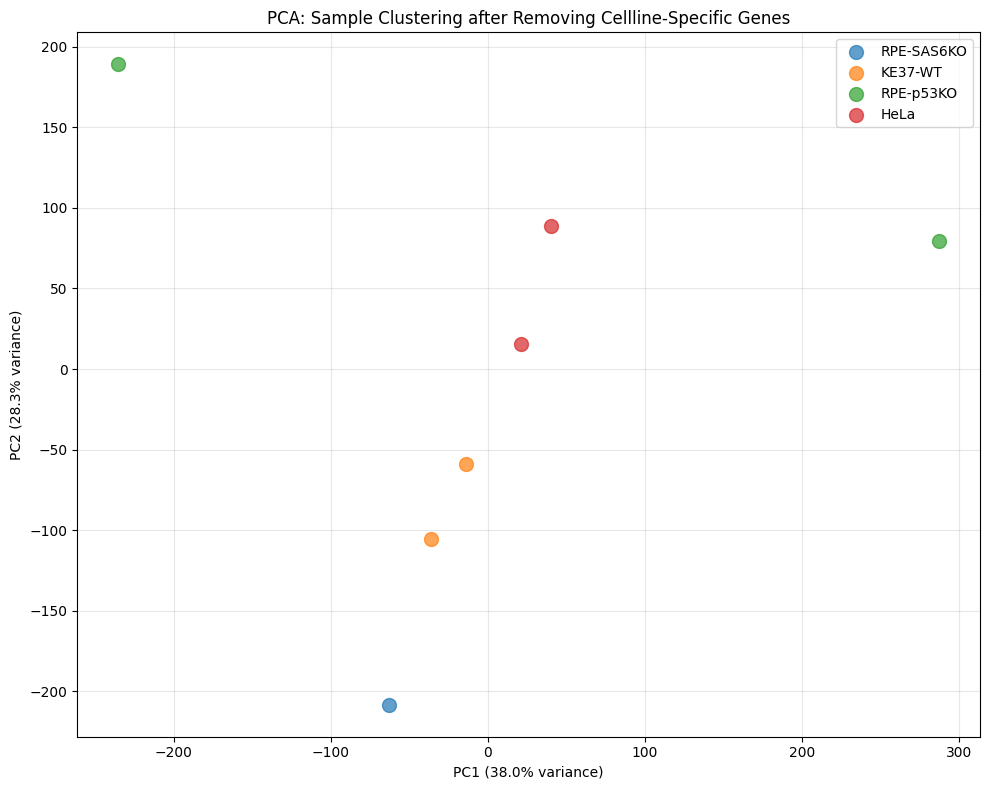

In [26]:
plt.figure(figsize=(10, 8))
for condition in pca_df['cell_line'].unique():
    mask = pca_df['cell_line'] == condition
    plt.scatter(pca_df.loc[mask, 'PC1'], 
                pca_df.loc[mask, 'PC2'],
                label=condition, s=100, alpha=0.7)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title('PCA: Sample Clustering after Removing Cellline-Specific Genes')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [61]:
# final_genes strored in final_genes.csv
pd.Series(final_genes).to_csv('/home/jiguo/SeqAna_Pipe/final_genes.csv', index=0, header=['gene_id'])

### Comparing the Variation between 2 replicates

In [ ]:
# plot MA plot for all the Replicates
# For RPE

In [ ]:
centriole_samples = sample_info[(sample_info['condition']=='with_centrioles') & (sample_info['cell_line']=='RPE-p53KO')].index
control_samples = sample_info[sample_info['condition']=='without_centrioles'].index
# use CPM values
centriole_counts = log_cpm[centriole_samples]
control_counts = log_cpm[control_samples]

# calculate mean expression and fold change
mean_centrioles = centriole_counts.mean(axis=1)
control_expr = control_counts.mean(axis=1)
fold_change = mean_centrioles - control_expr
mean_expr = (mean_centrioles + control_expr) / 2